In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [65]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles_3"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))


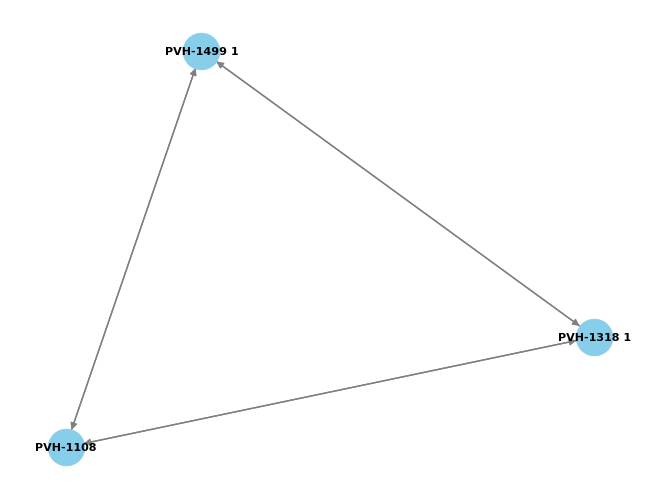

In [66]:
#%%
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 4: #3
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
# pos = nx.get_node_attributes(G, 'pos')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections within 200m')
plt.show()

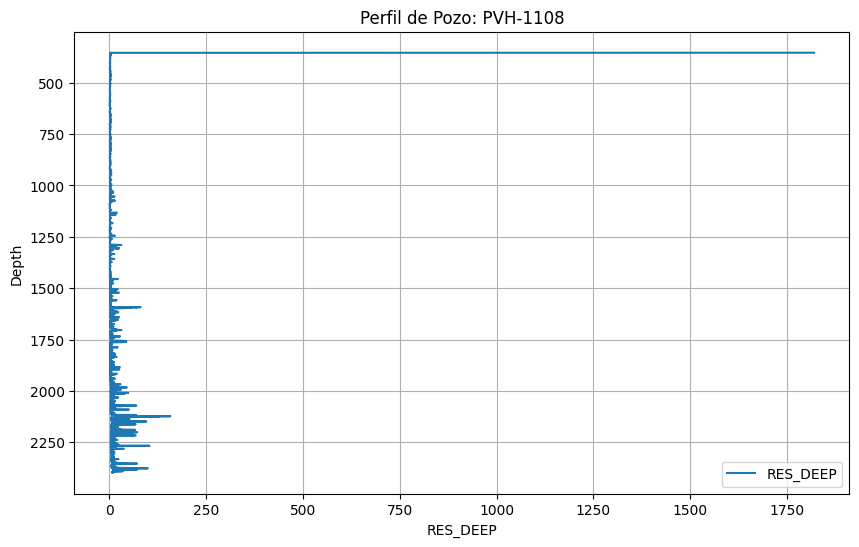

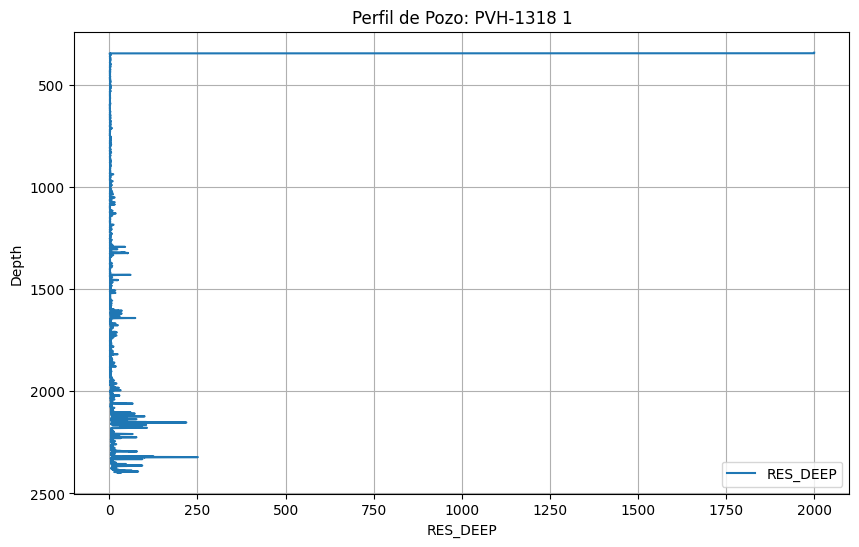

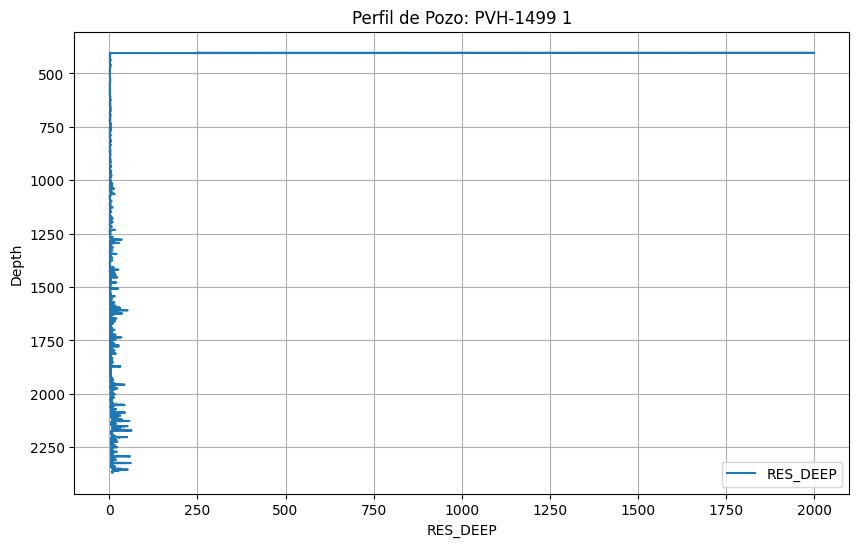

In [67]:
def getProfile(G, node):
    
    data = G.nodes[node]['data']
    
    plt.figure(figsize=(10, 6))
    for column in data.columns:
        if column != 'DEPTH':
            plt.plot(data[column], data['DEPTH'], label=column)
    
    plt.gca().invert_yaxis()
    plt.xlabel('RES_DEEP')
    plt.ylabel('Depth')
    plt.title(f'Perfil de Pozo: {node}')
    plt.legend()
    plt.grid(True)
    plt.show()


for node in G:
    getProfile(G, node)

Identify Tops
Note: this seems to only work when current node "pozo" is 1318 1

In [68]:
ruta_archivo = ruta_logs +"/Capas O PVH-1318_PVH-1499.xls"

# Leer el archivo usando pandas
tops = pd.read_excel(ruta_archivo)
tops=tops[tops["Pozo"]=="PVH-1318"]
a = tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
tops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(tops.head(10))


plt.show()

G.nodes['PVH-1318 1']["tops"]=tops

       Pozo  Capa        Ref
0  PVH-1318   O4T  1600.6632
1  PVH-1318   O5T  1614.4039
2  PVH-1318  O5aT  1624.3099
3  PVH-1318  O5bT  1630.0619
4  PVH-1318   O7T  1639.0092
5  PVH-1318   O4T  1610.2498
6  PVH-1318   O5T  1619.7299
7  PVH-1318  O5aT  1626.8663
8  PVH-1318  O5bT  1633.5769
9  PVH-1318   O7T  1642.5242


In [69]:

vtops = pd.read_excel(ruta_archivo)
vtops=vtops[vtops["Pozo"]=="PVH-1499"]
a = vtops.loc[vtops["Pozo"] == "PVH-1499", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=vtops.loc[vtops["Pozo"] == "PVH-1499", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
vtops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(vtops.head(10))


plt.show()

       Pozo  Capa        Ref
0  PVH-1499   O4T  1592.4712
1  PVH-1499   O5T  1606.4203
2  PVH-1499  O5aT  1616.9452
3  PVH-1499  O5bT  1622.1523
4  PVH-1499   O7T  1629.9545
5  PVH-1499   O4T  1601.8442
6  PVH-1499   O5T  1611.4777
7  PVH-1499  O5aT  1620.5903
8  PVH-1499  O5bT  1625.8013
9  PVH-1499   O7T  1634.1488


Finally using DTW Algorithm, can start from here.

C:\Users\User\AppData\Local\Temp\ipykernel_17892\2852682642.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


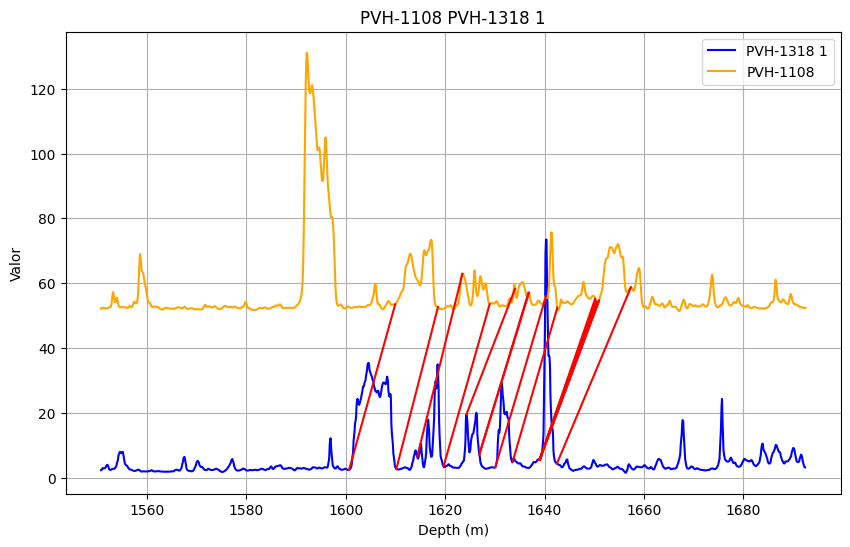

C:\Users\User\AppData\Local\Temp\ipykernel_17892\2852682642.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


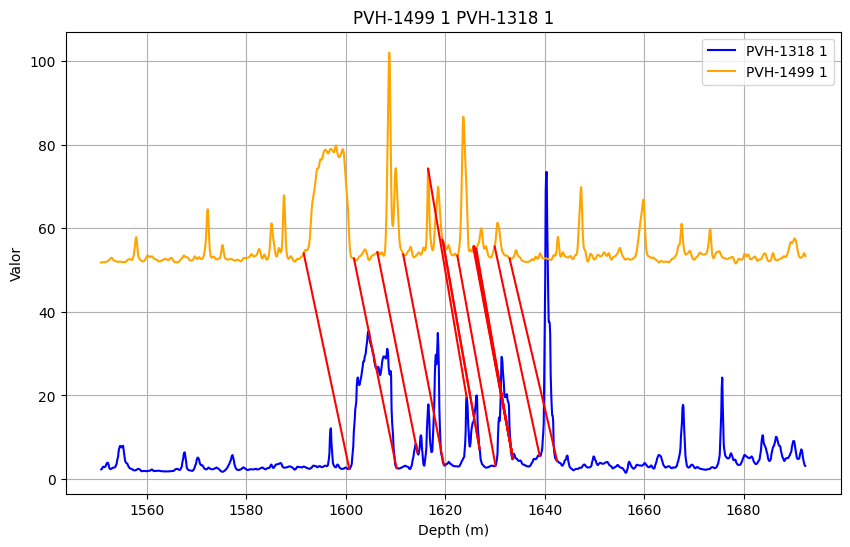

In [80]:

# only works when this is current node, need to make this more universal
pozo='PVH-1318 1'

def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.1)


neighbors = list(G.successors(pozo))
tolerance = 0.05
df1 = G.nodes[pozo]["data"]
tops = G.nodes[pozo]["tops"]
df1['Present'] = 0 #New column to mark the presence of tops

for nodo in neighbors:
    df2 = G.nodes[nodo]["data"]

    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1 #mark rows within the tolerance range of any top

    #print(df1.head(10))

    #Filter df1 and df2 to only include depths around tops
    G.nodes[pozo]["topes"] = df1[df1['Present'] == 1] # store the filtered rows near the topes into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()

    # print(df1.head(10))

    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w1_normalized = normalize_array(w1)
    df1['w1_normalized'] = w1_normalized

    w2 = np.array(df2['RES_DEEP'].dropna())
    w2_normalized = normalize_array(w2)

    #DTW Distance
    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    correla = [tupla for tupla in path if tupla[0] in ref.index]
    correla2 = [tupla[1] for tupla in correla]

    #mark tops in df2
    df2["topes"] = 0
    for elemento in correla2:
        if elemento in df2.index:
            df2.loc[elemento, "topes"] = 1
    G.nodes[nodo]["topes"] = df2[df2["topes"] == 1]
    G.nodes[nodo]["Procesados"] = df2




    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=pozo, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=nodo, color='orange')

    # Add results to a new dataframe
    df_result = pd.DataFrame(columns=["Capa",'Ref'])
    j_values_dict = {}


    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')
        # create a list of j values for unique i values
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths)
        #print(f'i = {i_depth}, j = {j_depth}')
        rows_to_add.append({'Ref': j_depth})
    
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    G.nodes[nodo]["topes"]=pd.DataFrame()
    G.nodes[nodo]["topes"] = df_result

    plt.title(nodo + " " + pozo)
    plt.xlabel('Depth (m)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()




In [118]:
# Calculate the closest 'Ref' point and update the 'Capa' column
def find_closest_capa(df_topes, vtops):
    capas = []
    for ref in df_topes['Ref']:
        closest_idx = (vtops['Ref'] - ref).abs().idxmin()
        closest_capa = vtops.loc[closest_idx, 'Capa']
        capas.append(closest_capa)
    return capas

# Assign the closest 'Capa' to the 'topes' DataFrame
df_topes = G.nodes["PVH-1499 1"]["topes"]
df_topes['Capa'] = find_closest_capa(df_topes, vtops)

# Print the updated DataFrame
print(df_topes)

vtops_sorted = vtops.sort_values(by='Ref', ascending=True).reset_index()

# Print the sorted DataFrame
print(vtops_sorted)


   Capa        Ref
0   O4T  1591.5332
1   O4T  1601.6332
2   O5T  1606.3332
3   O5T  1611.5332
4  O5aT  1616.5332
5  O5aT  1619.4832
6  O5bT  1622.4332
7  O5bT  1625.9332
8   O7T  1629.9332
9   O7T  1632.9332
   index      Pozo  Capa        Ref
0      0  PVH-1499   O4T  1592.4712
1      5  PVH-1499   O4T  1601.8442
2      1  PVH-1499   O5T  1606.4203
3      6  PVH-1499   O5T  1611.4777
4      2  PVH-1499  O5aT  1616.9452
5      7  PVH-1499  O5aT  1620.5903
6      3  PVH-1499  O5bT  1622.1523
7      8  PVH-1499  O5bT  1625.8013
8      4  PVH-1499   O7T  1629.9545
9      9  PVH-1499   O7T  1634.1488


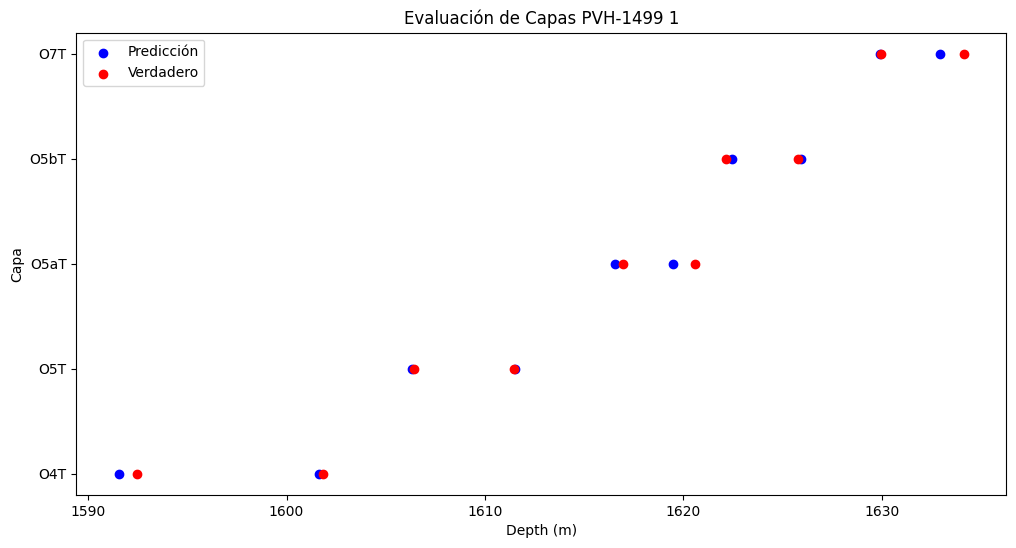

In [119]:
# Resultados
plt.figure(figsize=(12, 6))
plt.scatter(df_topes['Ref'], df_topes['Capa'], color='blue', label='Predicción')
plt.scatter(vtops['Ref'], vtops['Capa'], color='red', label='Verdadero')

plt.xlabel('Depth (m)')
plt.ylabel('Capa')
plt.title('Evaluación de Capas PVH-1499 1')
plt.legend()
plt.show()


  Capa_x   Ref_pred   Ref_true      Pozo Capa_y
0    O4T  1591.5332  1592.4712  PVH-1499    O4T
1    O4T  1601.6332  1601.8442  PVH-1499    O4T
2    O5T  1606.3332  1606.4203  PVH-1499    O5T
3    O5T  1611.5332  1611.4777  PVH-1499    O5T
4   O5aT  1616.5332  1616.9452  PVH-1499   O5aT
5   O5aT  1619.4832  1620.5903  PVH-1499   O5aT
6   O5bT  1622.4332  1622.1523  PVH-1499   O5bT
7   O5bT  1625.9332  1625.8013  PVH-1499   O5bT
8    O7T  1629.9332  1629.9545  PVH-1499    O7T
9    O7T  1632.9332  1634.1488  PVH-1499    O7T
Resumen estadístico:
       Error_Absoluto  Error_Porcentual
count       10.000000         10.000000
mean         0.446040          0.027586
std          0.461323          0.028463
min          0.021300          0.001307
25%          0.098300          0.006095
50%          0.245950          0.015244
75%          0.806500          0.050547
max          1.215600          0.074387
Error Medio Absoluto (MAE): 0.4460399999999936
Error Cuadrático Medio (MSE): 0.390488553999

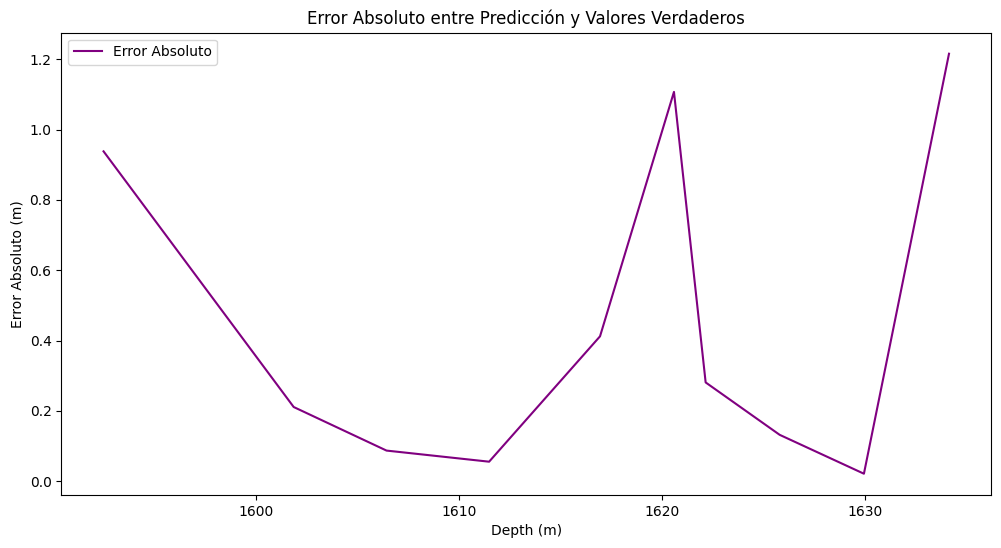

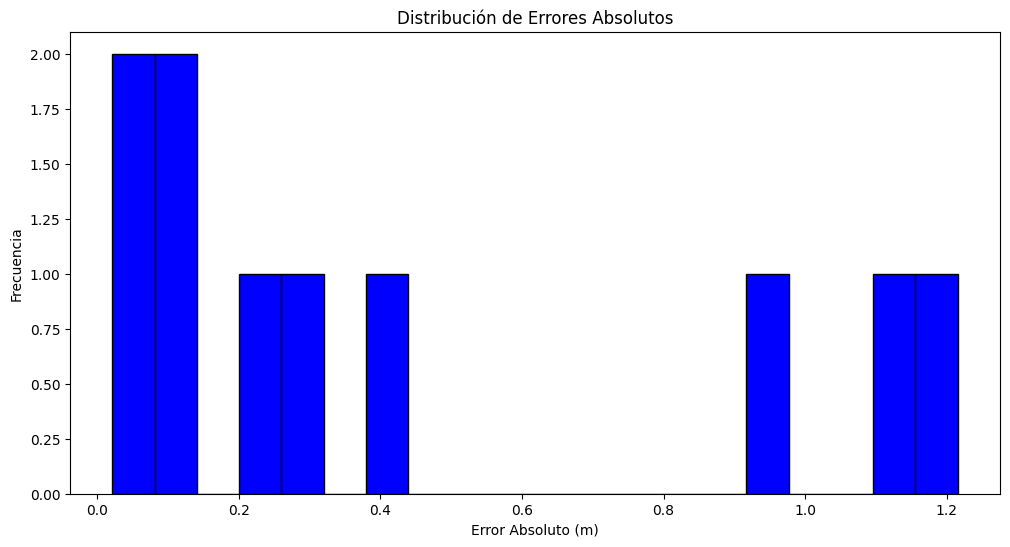

In [124]:
# Calcular la diferencia absoluta entre las predicciones y los valores verdaderos
df_merged = pd.merge_asof(df_topes.sort_values('Ref'), vtops.sort_values('Ref'), on='Ref', direction='nearest')
df_merged.rename(columns={"Ref": "Ref_pred"}, inplace=True)
df_merged.insert(2, "Ref_true", vtops_sorted['Ref'])
print(df_merged)


df_merged['Error_Absoluto'] = np.abs(df_merged['Ref_pred'] - df_merged['Ref_true'])
df_merged['Error_Porcentual'] = df_merged['Error_Absoluto'] / df_merged['Ref_true'] * 100

# Resumen estadístico
estadisticas = df_merged[['Error_Absoluto', 'Error_Porcentual']].describe()

# Calcular MAE y MSE
mae = df_merged['Error_Absoluto'].mean()
mse = (df_merged['Error_Absoluto'] ** 2).mean()

print("Resumen estadístico:")
print(estadisticas)
print(f"Error Medio Absoluto (MAE): {mae}")
print(f"Error Cuadrático Medio (MSE): {mse}")

# Gráfico de errores absolutos
plt.figure(figsize=(12, 6))
plt.plot(df_merged['Ref_true'], df_merged['Error_Absoluto'], label='Error Absoluto', color='purple')
plt.xlabel('Depth (m)')
plt.ylabel('Error Absoluto (m)')
plt.title('Error Absoluto entre Predicción y Valores Verdaderos')
plt.legend()
plt.show()

# Histograma de errores absolutos
plt.figure(figsize=(12, 6))
plt.hist(df_merged['Error_Absoluto'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Error Absoluto (m)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Absolutos')
plt.show()


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time



# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.1)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# return: a dataframe with the predicted depths
def calc_tops(G, node1, node2):
    tolerance = 0.05
    df1 = G.nodes[node1]["data"] # RES_DEEP data for node1
    tops = G.nodes[node1]["tops"] # Tops data for node1

    df2 = G.nodes[node2]["data"] # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1

    G.nodes[node1]["topes"] = df1[df1['Present'] == 1] # store the filtered rows near the topes into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w1_normalized = normalize_array(w1)
    df1['w1_normalized'] = w1_normalized

    w2 = np.array(df2['RES_DEEP'].dropna())
    w2_normalized = normalize_array(w2)


    # Calculate DTW Distance
    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    correla = [tupla for tupla in path if tupla[0] in ref.index]
    correla2 = [tupla[1] for tupla in correla]

    #mark tops in df2
    df2["topes"] = 0
    for elemento in correla2:
        if elemento in df2.index:
            df2.loc[elemento, "topes"] = 1
    G.nodes[node2]["topes"] = df2[df2["topes"] == 1]
    G.nodes[node2]["Procesados"] = df2

    # create a list of j values for unique i values
    df_result = pd.DataFrame(columns=["Capa",'Ref'])
    j_values_dict = {}
    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths)
        #print(f'i = {i_depth}, j = {j_depth}')
        rows_to_add.append({'Ref': j_depth})
    capas = ["O4T", "O4T", "O5T", "O5T", "O5aT", "O5aT", "O5bT", "O5bT", "O7T", "O7T", ]
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    df_result["Capa"] = capas
    return df_result

print(calc_tops(G, "PVH-1318 1", "PVH-1499 1"))

   Capa        Ref
0   O4T  1591.5332
1   O4T  1601.6332
2   O5T  1606.3332
3   O5T  1611.5332
4  O5aT  1616.5332
5  O5aT  1619.4832
6  O5bT  1622.4332
7  O5bT  1625.9332
8   O7T  1629.9332
9   O7T  1632.9332


C:\Users\User\AppData\Local\Temp\ipykernel_17892\1756812236.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
